In [91]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

from util import utils as data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

json_file = './results/permute_noise_0_48/bootstrap_var_setting_1/checkpoint_40.json'
FDIR = os.path.dirname(json_file)
NUM_CLASSIFY = 10

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# Plot gradients norms for the entire learning process
grads_json_filename = os.path.join(FDIR, 'model_grads.json')
grads = [[], [], []]
grads_key = ['max_grad_w1_16', 'max_grad_w1_32', 'max_grad_w1_64']
if os.path.exists(grads_json_filename):
    with open(grads_json_filename, 'r') as fp:
        data = json.load(fp)
        for i, k in enumerate(grads_key):
            if data[0].get(k, None) is None:
                continue
            for batch_grads in data:
                grads[i].append(batch_grads[k])

def plot_grads(grads, title, x_label, y_label, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    # plt.subplot(2, 1, 1)
    plt.plot(grads)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
for i, g in enumerate(grads):
    if len(g) > 0:
        plot_grads(g, grads_key[i], 'iterations', grads_key[i])
        # pass

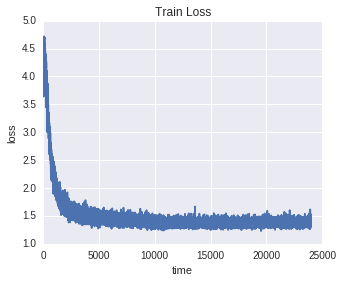

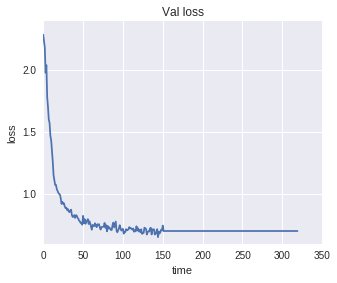

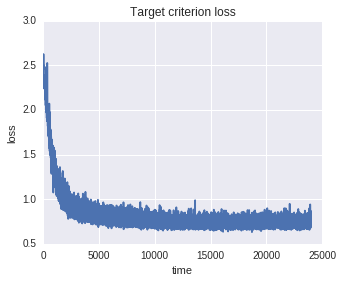

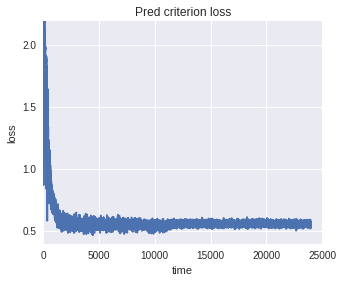

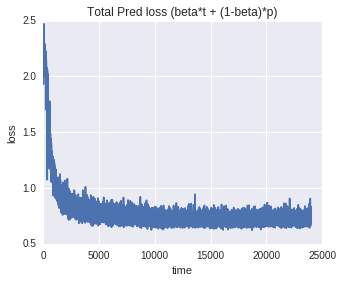

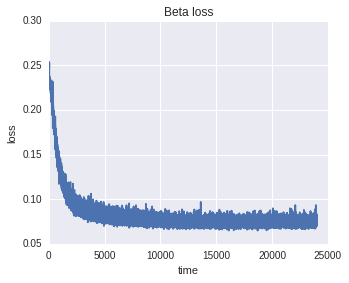

In [93]:
with open(json_file, 'r') as fp:
    data = json.load(fp)
# Loss history might not be of equal length.
train_loss_hist = data['train_loss_history']
val_loss_hist = data['val_loss_history']

# pdb.set_trace()
def plot_loss_hist(loss_hist, title,):
    plt.figure(figsize=(5,4))
    plt.subplot(1, 1, 1)
    plt.plot(loss_hist)
    plt.title(title)  # Train Loss
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()
    
plot_loss_hist(train_loss_hist, 'Train Loss')
plot_loss_hist(val_loss_hist, 'Val loss')

if data.get('crit1_loss_history', None) is not None:
    plot_loss_hist(data['crit1_loss_history'], 'Target criterion loss')

if data.get('crit2_loss_history', None) is not None:
    plot_loss_hist(data['crit2_loss_history'], 'Pred criterion loss')

if data.get('pred_loss_history', None) is not None:
    plot_loss_hist(data['pred_loss_history'], 'Total Pred loss (beta*t + (1-beta)*p)')    

if data.get('beta_loss_history', None) is not None:
    plot_loss_hist(data['beta_loss_history'], 'Beta loss')

In [94]:
if data.get('KL_loss_history', None) is not None:
    # Loss history might not be of equal length.
    KL_loss_hist = data['KL_loss_history']

    plt.figure(figsize=(10,8))
    plt.plot(KL_loss_hist)
    plt.title('KL loss')
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()

In [95]:
def get_conf(json_file, num_classes=26, json_key='conf'):
    with open(json_file, 'r') as fp:
        data = json.load(fp)
        conf = data.get(json_key, None)
    if conf is None:
        return
    # c1 = conf.split('\n')[1].split("]")[0].split("[ ")[1].split(" ")
    c1 = conf.split('\n')
    # print(c1)
    conf_mat, row_idx = np.zeros((num_classes, num_classes)), 0
    for i in c1:
        #pdb.set_trace()
        is_conf_row = False
        if ']' in i and '[[' in i:
            val = i.split(']')[0].split('[[')[1].split(' ')
            is_conf_row = True
        elif ']' in i and '[' in i:
            val = i.split(']')[0].split('[')[1].split(' ')
            is_conf_row = True
        if is_conf_row:
            col_idx = 0
            for v in val:
                if not len(v):
                    continue
                try:
                    conf_mat[row_idx, col_idx] = int(v)
                    col_idx = col_idx + 1
                except:
                    continue
            row_idx = row_idx + 1
    
    assert(row_idx == num_classes)
    conf_mat = conf_mat.astype(int)
    fdir = os.path.dirname(json_file)
    json_name = os.path.basename(json_file)[:-5]
    conf_file_name = fdir + '/' + 'conf_' + json_name + '.txt'
    np.savetxt(conf_file_name, conf_mat, fmt='%d', delimiter=', ')
    return conf_mat


def plot_conf(norm_conf):
  # Plot using seaborn
  # (this is style I used for ResNet matrix)
  plt.figure(figsize=(10,6))
  df_cm = pd.DataFrame(norm_conf)
  sns.heatmap(df_cm, annot=True, cmap="Blues")
  plt.show()

In [96]:
def get_sorted_checkpoints(fdir):
    # Checkpoint files are named as 'checkpoint_%d.json'
    checkpoint_map = {}
    for f in os.listdir(fdir):
        if f.endswith('json') and f.startswith('checkpoint'):
            checkpoint_num = int(f.split('checkpoint_')[-1].split('.')[0])
            checkpoint_map[checkpoint_num] = f
    sorted_checkpoints = []
    for k in sorted(checkpoint_map.keys()):
        v = checkpoint_map[k]
        sorted_checkpoints.append(v)
    return sorted_checkpoints

In [97]:
def best_f_scores(fdir, num_classes=5): 
    best_checkpoints = [None, None, None]
    best_3_fscores = [0, 0, 0]
    best_confs = [np.array(()), np.array(()), np.array(())]
    f1_weight_list = [1.0] * num_classes
    f1_weights = np.array(f1_weight_list)
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    for f in sorted_checkpoint_files:
        json_file = fdir + '/' + f
        conf = get_conf(json_file, num_classes, json_key='val_conf')
        norm_conf = data_utils.normalize_conf(conf)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
                f, f1, kappa, wt_f1))
        plot_conf(norm_conf)
        max_idx = -1
        for i in range(len(best_3_fscores)):
            if best_3_fscores[i] > f1:
                break
            max_idx = i
        for j in range(max_idx):
            best_3_fscores[j] = best_3_fscores[j+1]
            best_confs[j] = best_confs[j+1]
            best_checkpoints[j] = best_checkpoints[j+1]

        best_3_fscores[max_idx] = f1
        best_confs[max_idx] = conf
        best_checkpoints[max_idx] = f

    return best_3_fscores, best_confs, best_checkpoints

[[141789    379    687    988    504    244  65214    339    638  28218]
 [   492 115085    857   1230   3242    328    675  55772   1480  73199]
 [  2433   1001 168638   1446    944  41801   1119   2214   6410    754]
 [   930   1157   3082  71107    664    260    702   1752 157806    980]
 [  1224   2149    495    918 137648    176  26438  71205    853   1574]
 [  2715    759 157486   1583    852  54272   1257   1974   6774    728]
 [ 42989   1401    471    833  77039    292 108616    783    571    645]
 [   170  72523    934    982  41523    386    198 144272    791    821]
 [   913   1484   2724  57498    996    358    547   1902 173592    826]
 [ 78553  30036    443   1027   3455     20    555   1459   1469 118263]]
file: <built-in method f of mtrand.RandomState object at 0x7f07e2718280>, f1: 0.501, kappa: 0.190, weighted-F1: 0.502


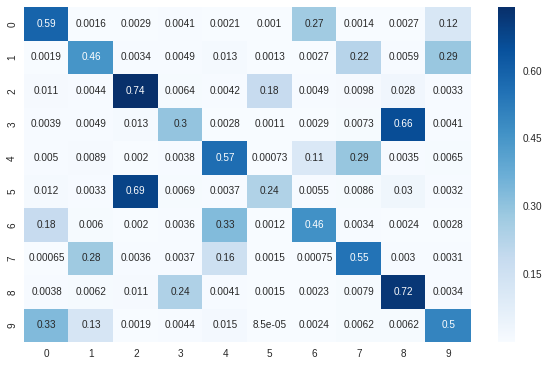

In [98]:
def plot_train_conf(fdir, num_classes=5):
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    if len(sorted_checkpoint_files) > 0:
        last_checkpoint = sorted_checkpoint_files[-1]
        json_file = fdir + '/' + last_checkpoint
        conf = get_conf(json_file, num_classes=num_classes, json_key='train_conf')
        print(conf)
        norm_conf = data_utils.normalize_conf(conf)
        f1_weight_list = [1.0] * num_classes
        f1_weights = np.array(f1_weight_list)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
            f, f1, kappa, wt_f1))
        plot_conf(norm_conf)

plot_train_conf(FDIR, num_classes=NUM_CLASSIFY)

file: checkpoint_1.json, f1: 0.217, kappa: 0.064, weighted-F1: 0.216


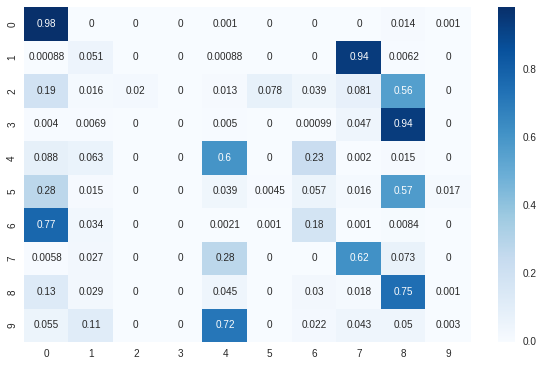

file: checkpoint_2.json, f1: 0.439, kappa: 0.301, weighted-F1: 0.437


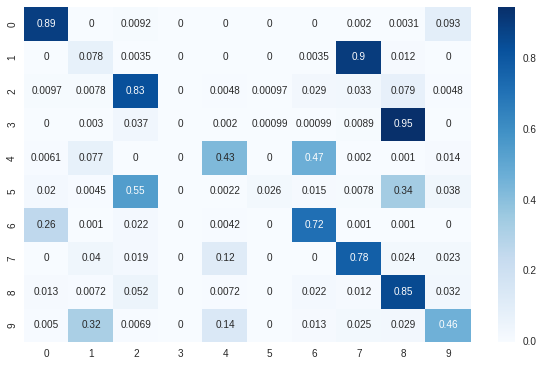

file: checkpoint_3.json, f1: 0.495, kappa: 0.384, weighted-F1: 0.496


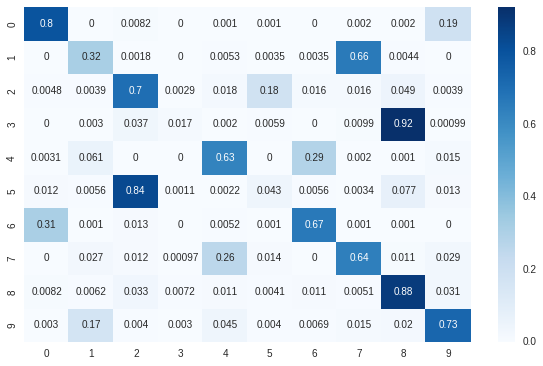

file: checkpoint_4.json, f1: 0.479, kappa: 0.330, weighted-F1: 0.481


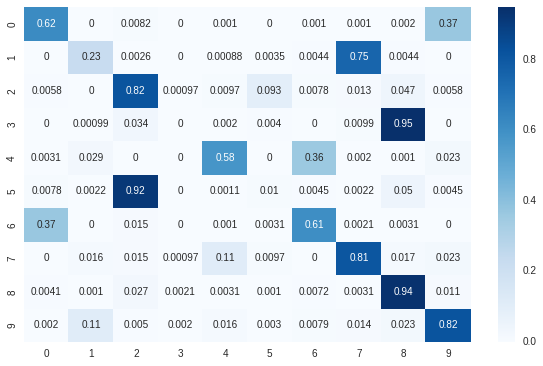

file: checkpoint_5.json, f1: 0.495, kappa: 0.386, weighted-F1: 0.498


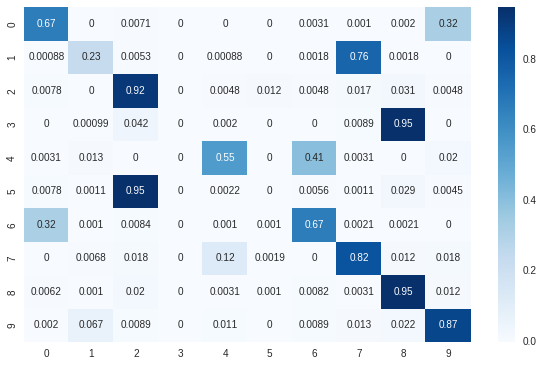

file: checkpoint_6.json, f1: 0.570, kappa: 0.523, weighted-F1: 0.575


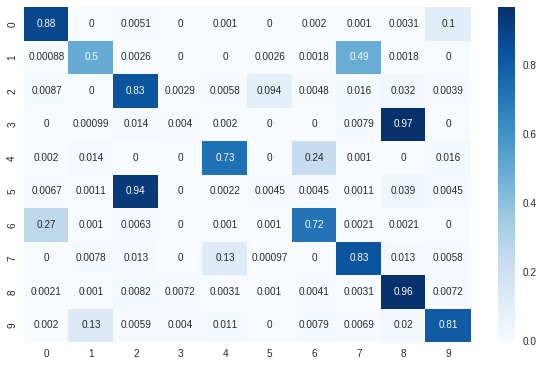

file: checkpoint_7.json, f1: 0.536, kappa: 0.381, weighted-F1: 0.541


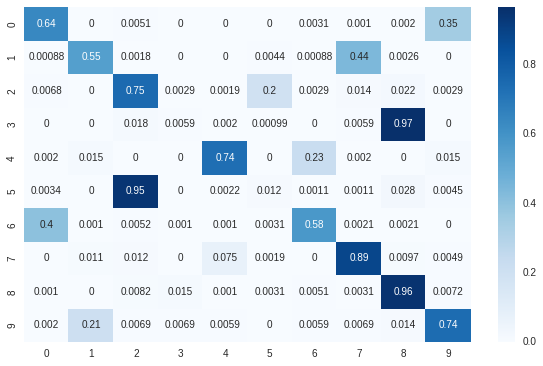

file: checkpoint_8.json, f1: 0.592, kappa: 0.470, weighted-F1: 0.598


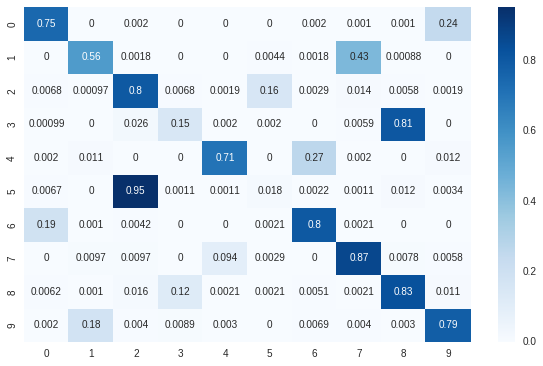

file: checkpoint_9.json, f1: 0.563, kappa: 0.433, weighted-F1: 0.570


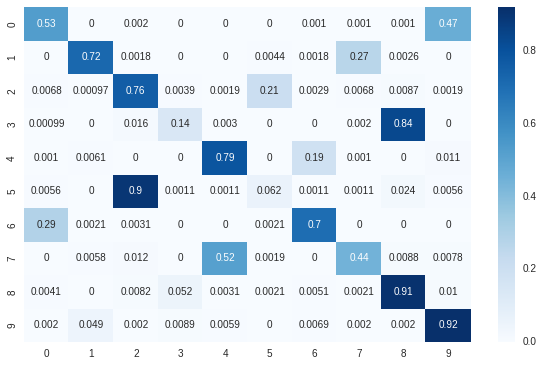

file: checkpoint_10.json, f1: 0.525, kappa: 0.450, weighted-F1: 0.530


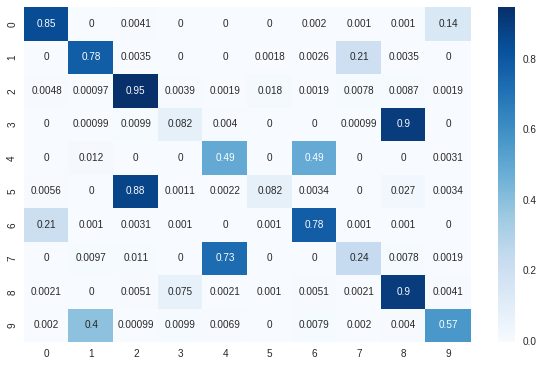

file: checkpoint_11.json, f1: 0.532, kappa: 0.403, weighted-F1: 0.540


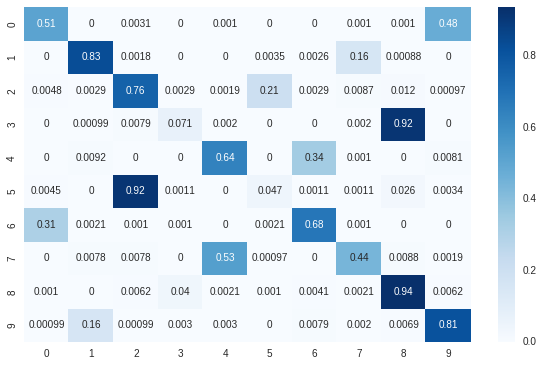

file: checkpoint_12.json, f1: 0.591, kappa: 0.480, weighted-F1: 0.594


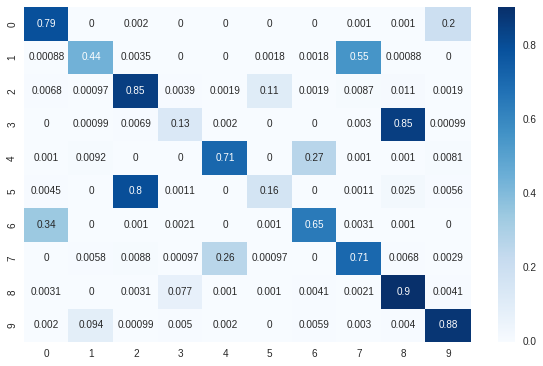

file: checkpoint_13.json, f1: 0.645, kappa: 0.579, weighted-F1: 0.648


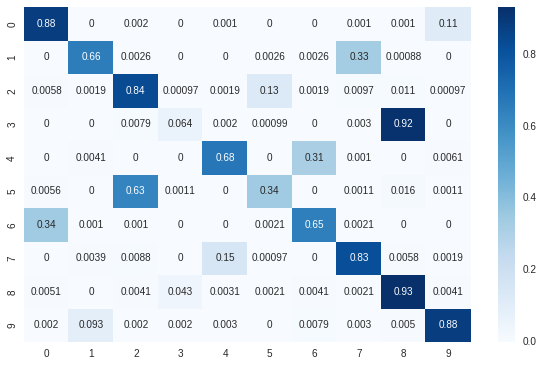

file: checkpoint_14.json, f1: 0.610, kappa: 0.418, weighted-F1: 0.614


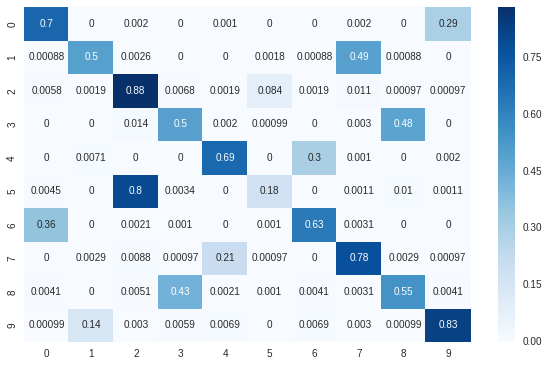

file: checkpoint_15.json, f1: 0.580, kappa: 0.293, weighted-F1: 0.581


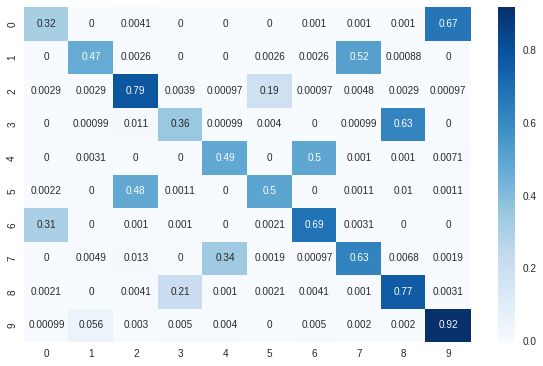

file: checkpoint_16.json, f1: 0.586, kappa: 0.315, weighted-F1: 0.589


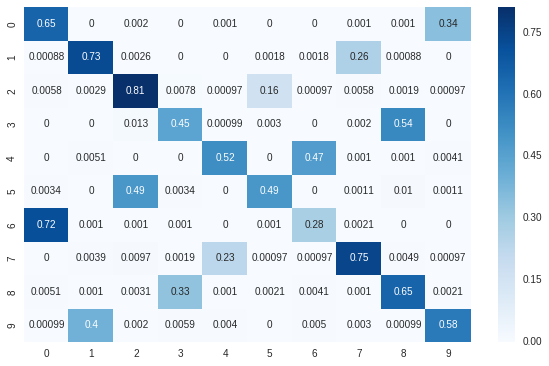

file: checkpoint_17.json, f1: 0.559, kappa: 0.384, weighted-F1: 0.562


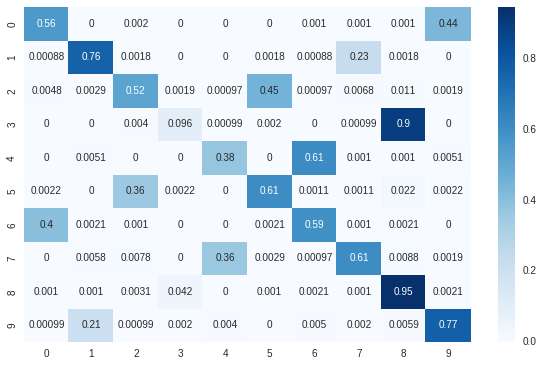

file: checkpoint_18.json, f1: 0.578, kappa: 0.399, weighted-F1: 0.572


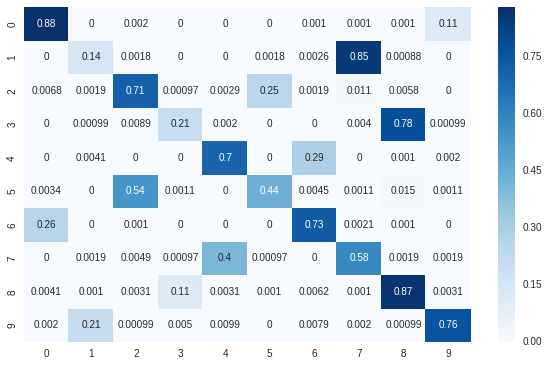

file: checkpoint_19.json, f1: 0.615, kappa: 0.383, weighted-F1: 0.616


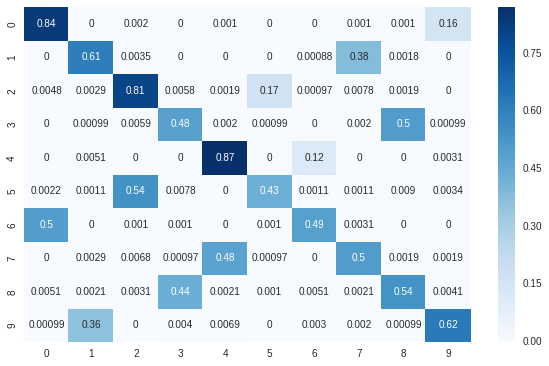

file: checkpoint_20.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


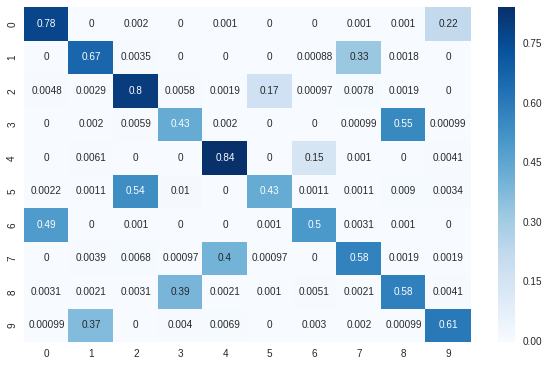

file: checkpoint_21.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


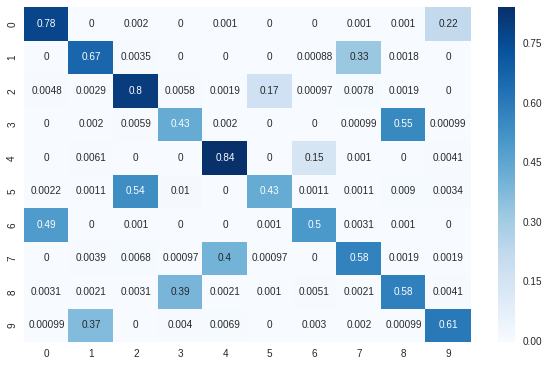

file: checkpoint_22.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


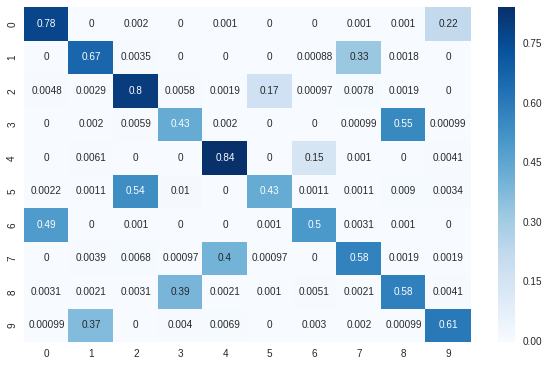

file: checkpoint_23.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


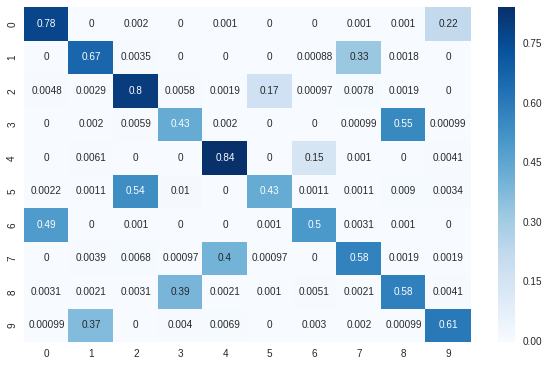

file: checkpoint_24.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


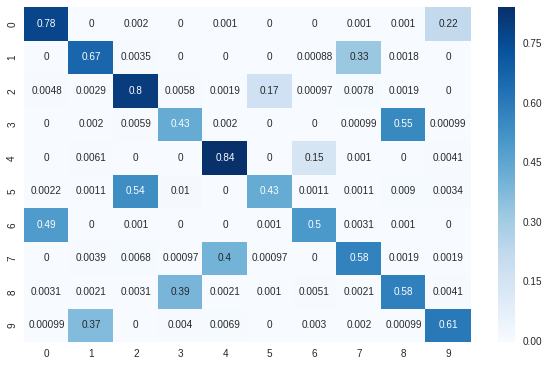

file: checkpoint_25.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


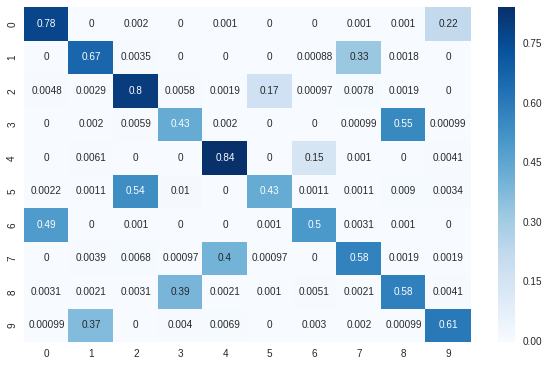

file: checkpoint_26.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


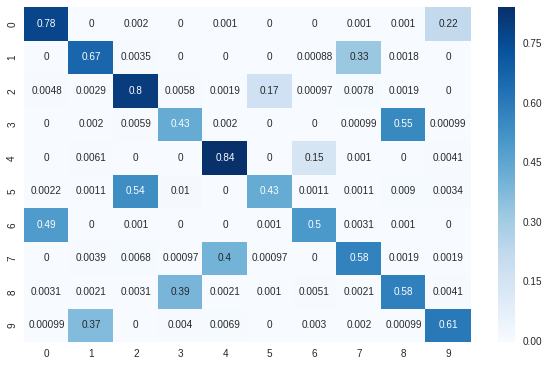

file: checkpoint_27.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


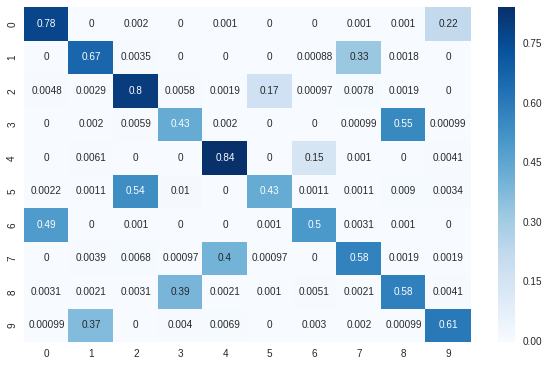

file: checkpoint_28.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


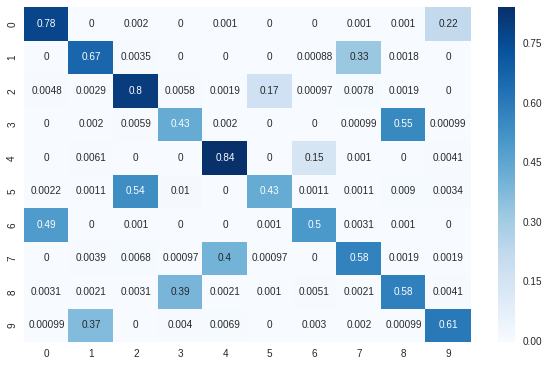

file: checkpoint_29.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


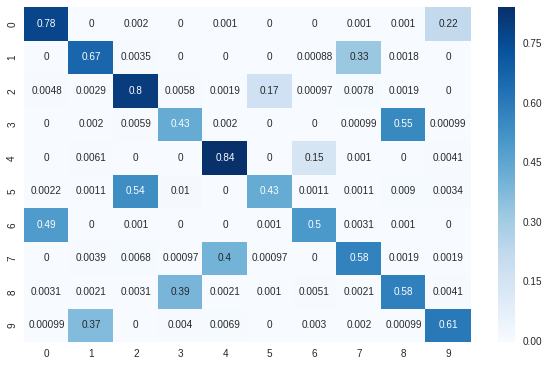

file: checkpoint_30.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


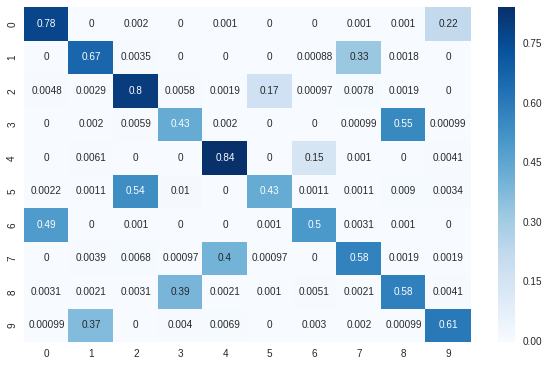

file: checkpoint_31.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


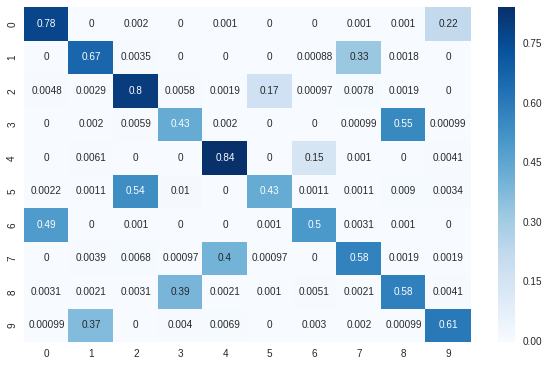

file: checkpoint_32.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


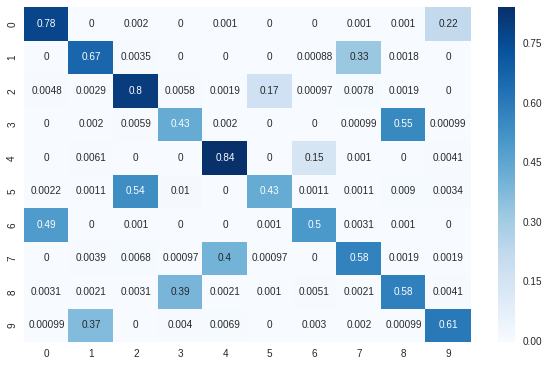

file: checkpoint_33.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


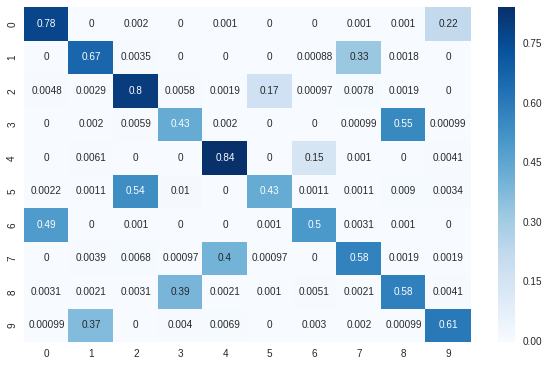

file: checkpoint_34.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


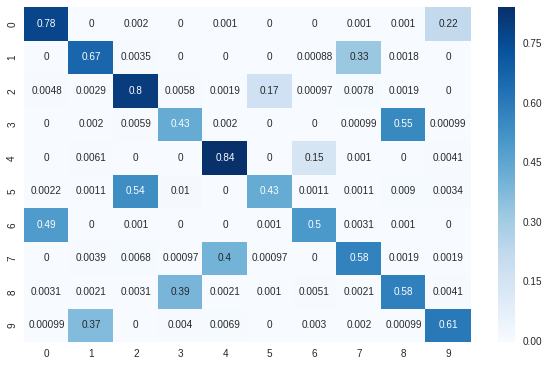

file: checkpoint_35.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


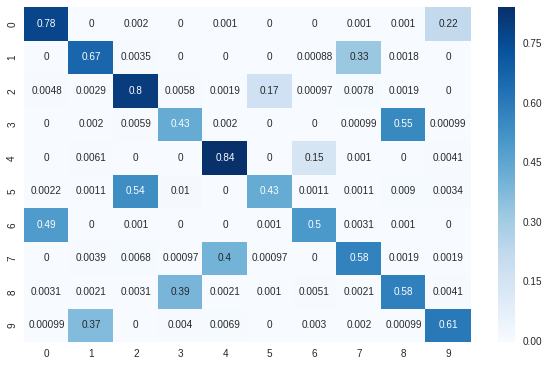

file: checkpoint_36.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


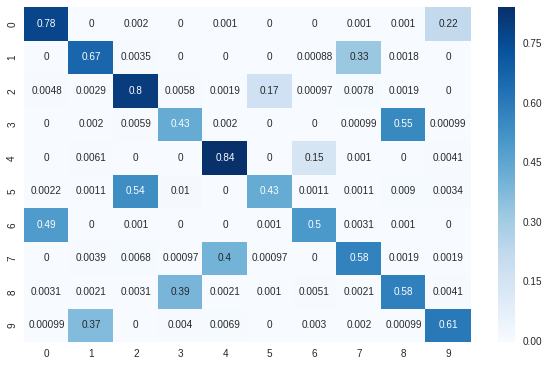

file: checkpoint_37.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


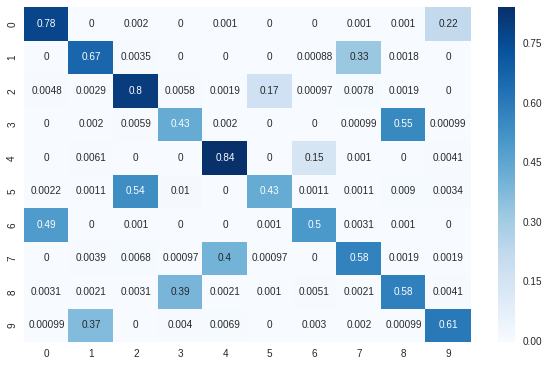

file: checkpoint_38.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


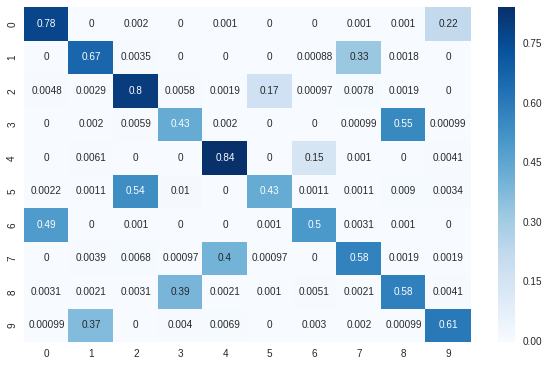

file: checkpoint_39.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


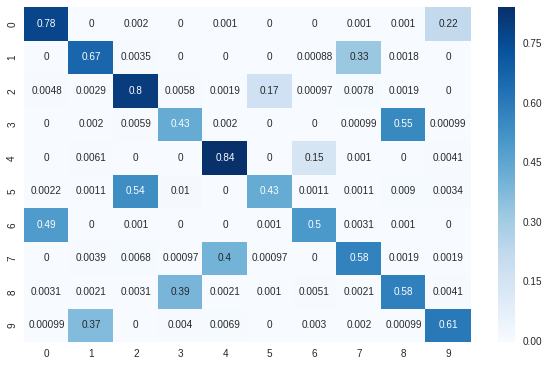

file: checkpoint_40.json, f1: 0.618, kappa: 0.373, weighted-F1: 0.620


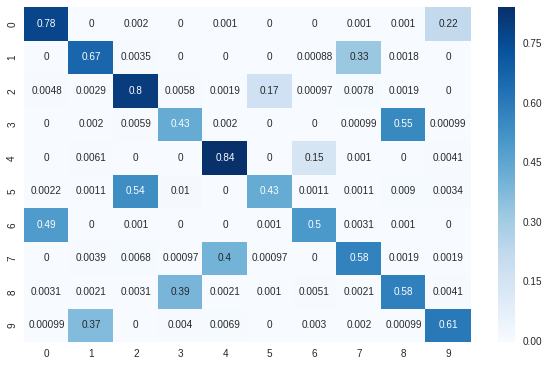

([0.61843322595020656, 0.61843322595020656, 0.61843322595020656],
 [array([[761,   0,   2,   0,   1,   0,   0,   1,   1, 214],
         [  0, 758,   4,   0,   0,   0,   1, 370,   2,   0],
         [  5,   3, 827,   6,   2, 178,   1,   8,   2,   0],
         [  0,   2,   6, 439,   2,   0,   0,   1, 559,   1],
         [  0,   6,   0,   0, 828,   0, 143,   1,   0,   4],
         [  2,   1, 481,   9,   0, 386,   1,   1,   8,   3],
         [472,   0,   1,   0,   0,   1, 480,   3,   1,   0],
         [  0,   4,   7,   1, 416,   1,   0, 595,   2,   2],
         [  3,   2,   3, 383,   2,   1,   5,   2, 569,   4],
         [  1, 377,   0,   4,   7,   0,   3,   2,   1, 614]]),
  array([[761,   0,   2,   0,   1,   0,   0,   1,   1, 214],
         [  0, 758,   4,   0,   0,   0,   1, 370,   2,   0],
         [  5,   3, 827,   6,   2, 178,   1,   8,   2,   0],
         [  0,   2,   6, 439,   2,   0,   0,   1, 559,   1],
         [  0,   6,   0,   0, 828,   0, 143,   1,   0,   4],
         [  2,   

In [99]:
best_f_scores(FDIR, num_classes=NUM_CLASSIFY)